In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls '/content/drive/My Drive/Eventlog/Combining'


Ex_2event1.csv		       Examplebadjulian_2events.xes
Ex_2event.csv		       Examplebadjulian_2events_xes_csv1.csv
Ex_3event1.csv		       examplebadjulian_3events.csv
Ex_3event.csv		       examplebadjulian_3events.pnml
Ex3_xes_2csv1.csv	       examplebadjulian_3events.xes
Ex3_xes_2csv.csv	       examplebadjulian_4events.csv
Ex_4event1.csv		       examplebadjulian_4events.pnml
Ex_4event.csv		       examplebadjulian_4events.xes
Ex4_xes_2csv1.csv	       examplebadjulian_5events.csv
Ex4_xes_2csv.csv	       examplebadjulian_5events.pnml
Ex_5event1.csv		       examplebadjulian_5events.xes
Ex_5event.csv		       Examplebadjulian_xes_2_csv.csv
Ex5_xes_2csv1.csv	       Ex_xes_2csv1.csv
Ex5_xes_2csv.csv	       Ex_xes_2csv.csv
Examplebadjulian_2events.csv   pnml_1event.csv
Examplebadjulian_2events.pnml


In [4]:
!pip install pm4py

In [0]:
#Importing library to read log file
from pm4py.objects.log.importer.xes import factory as xes_import_factory
import pandas as pd


## loading xes file and reading the file

In [0]:
#File path
filename = '/content/drive/My Drive/Eventlog/Combining/examplebadjulian_4events.xes'
log = xes_import_factory.apply(filename)

## converting xes to csv and reading the file using pandas

In [0]:
from pm4py.objects.log.exporter.csv import factory as csv_exporter
filename = "/content/drive/My Drive/Eventlog/Combining/examplebadjulian_4events_xes_csv4.csv"
csv_exporter.export(log, filename)

In [0]:
filename =  "/content/drive/My Drive/Eventlog/Combining/examplebadjulian_4events_xes_csv4.csv"
df_eventslog = pd.read_csv(filename)

In [9]:
df_eventslog.head()

case:concept:name  ...             time:timestamp
0                 88  ...  2013-03-17 17:56:00-05:00
1                 88  ...  2013-03-18 17:56:00-05:00
2                 88  ...  2013-03-19 17:56:00-05:00
3                 88  ...  2013-03-20 17:56:00-05:00
4                 88  ...  2013-03-20 17:56:00-05:00

[5 rows x 4 columns]

# Exploring  PNML file

In [10]:
import os
from pm4py.objects.petri.importer import pnml as pnml_importer
filename = "/content/drive/My Drive/Eventlog/Combining/examplebadjulian_4events.pnml"
net, initial_marking, final_marking = pnml_importer.import_net(filename)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function import_net.
  after removing the cwd from sys.path.


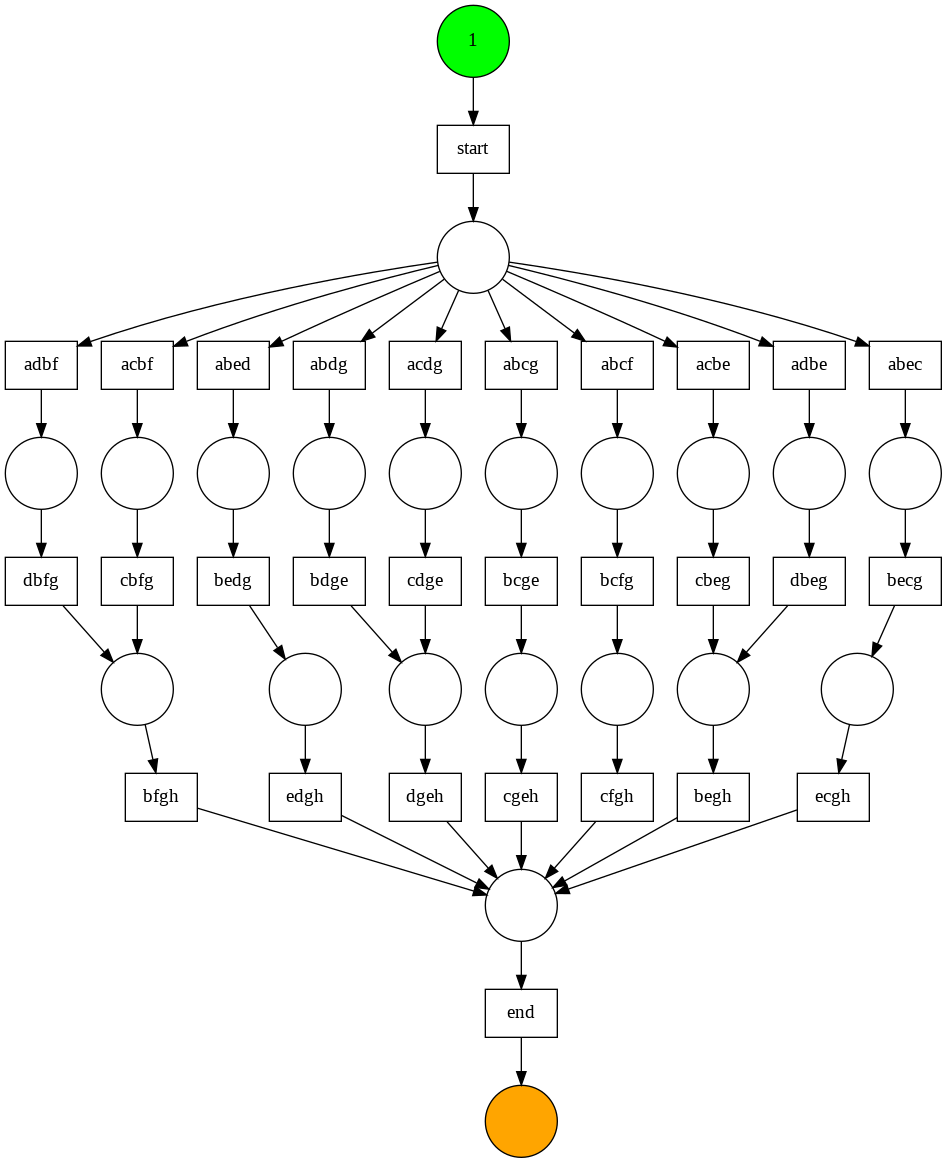

In [11]:
from pm4py.visualization.petrinet import factory as pn_vis_factory
gviz = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz)

In [0]:
from pm4py.objects.petri import semantics
transitions = semantics.enabled_transitions(net, initial_marking)

In [0]:
place = net.places
transitions = net.transitions
arc = net.arcs

## Token replay

In [0]:
# This functions gives places which goes to transitions
def trans_in(trans_inputs):
  import re
  trainsition_input = []
  place_out = []
  arc_s = str(trans_inputs)
  arc_clean = re.sub('[^A-Za-z0-9,->]+', '', arc_s)
  arc_f = arc_clean.split(",")
  
  for i in range(len(arc_f)):
    arc_f[i]=arc_f[i][1:]
    arc_f[i] = arc_f[i].split("->")
    trainsition_input.append(arc_f[i][1][1:])
    place_out.append(arc_f[i][0])
    
  return place_out,trainsition_input
  

trans_inputs = []
for place in net.places:
  for arc in place.out_arcs:
    trans_inputs.append(arc)
        
place_output,trans_input = trans_in(trans_inputs)

In [0]:
# This function gives transitions output which goes to places
def trans_out(trans_out):
  import re
  trainsition_output = []
  place_in = []
  arc_s = str(trans_out)
  arc_clean = re.sub('[^A-Za-z0-9,->]+', '', arc_s)
  arc_f = arc_clean.split(",")
  
  for i in range(len(arc_f)):
    arc_f[i]=arc_f[i][1:]
    arc_f[i] = arc_f[i].split("->")
    trainsition_output.append(arc_f[i][0]) 
    place_in.append(arc_f[i][1][1:])
    
  return trainsition_output,place_in 
  

transitions_out = []
for trans in transitions:
#trans_unique_name[trans.name]= trans.label
    for arc in trans.out_arcs:
        transitions_out.append(arc)
        
trans_output, place_input = trans_out(transitions_out)

In [0]:
# firing transition 
def fire_trans(trans, place_trans, trans_place):
  
  for i in place_trans:
    place_tokens[i] = 0
    if i not in place_p_c:
      place_p_c[i] = {}
      place_p_c[i]["c"] = 1
    else:
      place_p_c[i]["c"] = 1
         
  for i in trans_place:
    place_tokens[i] = 1
    if i not in place_p_c:
      place_p_c[i] = {}
      place_p_c[i]["p"] = 1
    else:
      place_p_c[i]["p"] = 1
       

In [0]:
# introducing start transition and putting one token in the output place 
def start_trans(trans_output,place_input,place_output,trans_input,place_p_c):
  for t , p in enumerate(zip(trans_output,place_input,place_output,trans_input)):
    if "start"  == p[0]:
      trans_place.append(p[1])
      #produce tokens
      for i in trans_place:
        place_tokens[i] = 1
        place_p_c[i] = {}
        place_p_c[i]["p"] = 1


In [0]:
# introducing End transition and producing and consuming one token in the input place to the end transition 
def end_trans(trans_output,place_input,place_output,trans_input,place_p_c):
  for t , p in enumerate(zip(trans_output,place_input,place_output,trans_input)):
    if "end"  == p[0]:
      place_before_end = place_output[trans_input.index('end')]
      place_tokens[place_before_end ] = 0
      if i not in place_p_c:
        place_p_c[i] = {}
        place_p_c[i]["c"] = 1
      else:
        place_p_c[i]["c"] = 1

            

In [0]:
def checking_hidden_transition(tran_obs,place_trans,trans_place):
   
  filterd_hidden_trans = []
  trans_to_place = []
  
  # Going back to transition to place
  for i in place_trans:
    for t , p in enumerate(zip(trans_output,place_input,place_output,trans_input)):
      if i  == p[1]:
        trans_to_place.append(p[0])
         
  # Filtering hidden transition
  for trans in trans_to_place:  
    if trans in hidden_trans:
      filterd_hidden_trans.append(trans)


  #If a hidden transition presents between trace, this condintion will be true
  if len(filterd_hidden_trans ) == 1:
    # Getting place goes to the hidden transition
    place_to_hidden_trans = []
    for t , p in enumerate(zip(trans_output,place_input,place_output,trans_input)):
      if filterd_hidden_trans[0]  == p[3]:
        place_to_hidden_trans.append(p[2])
    
    
    for i in place_to_hidden_trans:
      if len(place_to_hidden_trans) ==1:
        if place_tokens[i] == 0:
          m = place_trans[0]
          if m not in place_p_c:             
            place_p_c[m] = {}
            place_p_c[m]["m"] = 1
            # Fire the hidden transition
            fire_trans(tran_obs ,place_trans,trans_place)
          else:
            place_p_c[m]["m"] = 1
            # Firing the hidden transition
            fire_trans(tran_obs ,place_trans,trans_place)    

            # If a hidden transition is not available, this condition will be true and then put a token in the place and fire the transition
        elif place_tokens[i] == 1:
          place_tokens[i] = 0
          
          if i not in place_p_c:
            place_p_c[i] = {}
            place_p_c[i]["c"] = 1
          else:
             place_p_c[i]["c"] = 1
            
          m = place_trans[0]
          #place_tokens[m] = 1
          if m not in place_p_c:             
            place_p_c[m] = {}
            place_p_c[m]["p"] = 1
            # Firing the transition
            fire_trans(tran_obs ,place_trans,trans_place)             
          else:    
            place_p_c[i]["c"] = 1
            place_p_c[m]["p"] = 1
            # Firing the transition
            fire_trans(tran_obs ,place_trans,trans_place)
              
  elif len(filterd_hidden_trans) == 0:
    m_trans = place_trans[0]
    if m_trans not in place_p_c:
      place_p_c[m_trans] = {}
      place_p_c[m_trans]["m"] = 1
      # Firing the transition
      fire_trans(tran_obs ,place_trans,trans_place)
    else:
      place_p_c[m_trans]["m"] = 1
      # Firing the transition
      fire_trans(tran_obs ,place_trans,trans_place)



In [0]:
def events(tran_obs,trans_output,place_input,place_output,trans_input,place_p_c):
  place_trans = []
  trans_place = []

  for t , p in enumerate(zip(trans_output,place_input,place_output,trans_input)):
    if tran_obs  == p[3]:
      place_trans.append(p[2])
    if tran_obs  == p[0]:
      trans_place.append(p[1])
      # Checking whether the incoming places has enough tokens or not
      # When a transitions has more than one incoming place, we have to check whether the incoming places has enough tokens or not
      # So we check token availability in each place one by one by for loop.
  for i in place_trans:
    # only If we have one incoming place to the transitions, this condition will be success.
    if len(place_trans) ==1:
      # If that place doesnt have a token, this condition will be true
      if place_tokens[i] == 0:
        checking_hidden_transition(tran_obs,place_trans,trans_place)
      # If a token is available in the place, this condition will be true.  
      elif place_tokens[i] == 1:
        place_p_c[i]["m"] = 0
        # Firing the transition
        fire_trans(tran_obs ,place_trans,trans_place)

In [0]:

unique_id = df_eventslog['case:concept:name'].unique()
file = {} 
for r in range(1,len(unique_id)+1):
  
  # Store p, c , m, and r value of each place   
  trace_pcmr = {}
  # Store p ,c and m value of each place
  place_p_c = {}
  
  #empty tokens
  place_tokens = {}

  for place in net.places:
      place_tokens[place.name] = 0
      
  # Find number of hidden transition   
  hidden_trans = []
  for i in range(len(trans_output)):
    if 'n' == trans_output[i][0]:
      hidden_trans.append(trans_output[i])
    
  row_filter = df_eventslog.loc[df_eventslog['case:concept:name']==r,:]
  row_filter  = row_filter.reset_index(drop=True)

  # for loop for one trace
  for n in range(len(row_filter)):
    
     # To store transition output to place input
      trans_place= []
      # To store place output to transition input
      place_trans = []
      # event
      tran_obs = row_filter.loc[row_filter['case:concept:name']==r,'concept:name'][n]
      
      if tran_obs == "start":
        start_trans(trans_output,place_input,place_output,trans_input,place_p_c)
        
      elif tran_obs == "end":
        end_trans(trans_output,place_input,place_output,trans_input,place_p_c)
        
      else :
        events(tran_obs,trans_output,place_input,place_output,trans_input,place_p_c)

  # This is for calculating remaing values
  for place, value in place_tokens.items():
    if value > 0:
      if place not in place_p_c:
        place_p_c[place] = {}
        place_p_c[place]['r'] = value
      else:
        place_p_c[place]['r'] = value
    else:
      if place not in place_p_c:
        place_p_c[place] = {}
        place_p_c[place]['r'] = 0
      else:
        place_p_c[place]['r'] = 0
      
  for k, v in place_p_c.items():
    for ik in v.keys():
      if ik not in trace_pcmr:
        trace_pcmr[ik] = v[ik]
      else :
        trace_pcmr[ik] += v[ik]
  
  file[r]=trace_pcmr
  




# Computing Fitnes 

In [22]:

def fitness(file):
  
  sum_of_c = 0
  sum_of_m = 0
  sum_of_r = 0
  sum_of_p = 0
  
  trace = {}
  
  for k, v in file.items():
    if k not in trace:
      trace[k] = {'c':0,'m':0,'p':0,'r':0}
      
      for ik, iv in trace[k].items():
        if ik == 'c' :
          trace[k][ik] = file[k][ik]  
        elif ik == 'm':
          trace[k][ik] = file[k][ik]
        elif ik == 'p':
          trace[k][ik] = file[k][ik] 
        else :
          trace[k][ik] = file[k][ik]
 
  
  for k, v in trace.items():

    for ik, iv in v.items():
      if ik == 'c' :
        sum_of_c += v[ik]
      elif ik == 'm':
        sum_of_m += v[ik]
      elif ik == 'p':
        sum_of_p += v[ik]
      else :
        sum_of_r += v[ik]
        
  fitness = 1/2 * (1-sum_of_m/sum_of_c) + 1/2 *(1-sum_of_r/sum_of_p)
  
  result = '%.2f' % fitness + ' %'
        
  return result
 
  
result = fitness(file)
result

'1.00 %'